# Lab assignment №1, part 3

This lab assignment consists of several parts. You are supposed to make some transformations, train some models, estimate the quality of the models and explain your results.

Several comments:
* Don't hesitate to ask questions, it's a good practice.
* No private/public sharing, please. The copied assignments will be graded with 0 points.
* Blocks of this lab will be graded separately.

__*This is the third part of the assignment. First and second parts are waiting for you in the same directory.*__

##  Part 3. SVM and kernels

Kernels concept get adopted in variety of ML algorithms (e.g. Kernel PCA, Gaussian Processes, kNN, ...).

So in this task you are to examine kernels for SVM algorithm applied to rather simple artificial datasets.

To make it clear: we will work with the classification problem through the whole notebook. 

In [1]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import numpy as np

Let's generate our dataset and take a look on it.

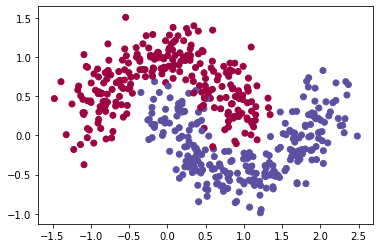

In [2]:
moons_points, moons_labels = make_moons(n_samples=500, noise=0.2, random_state=42)
plt.scatter(moons_points[:, 0], moons_points[:, 1], c=moons_labels, cmap=plt.cm.Spectral)
plt.show()

## 1.1 Pure models.
First let's try to solve this case with good old Logistic Regression and simple (linear kernel) SVM classifier.

Train LR and SVM classifiers (choose params by hand, no CV or intensive grid search neeeded) and plot their decision regions. Calculate one preffered classification metric.

Describe results in one-two sentences.

_Tip:_ to plot classifiers decisions you could use either sklearn examples ([this](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_alpha.html#sphx-glr-auto-examples-neural-networks-plot-mlp-alpha-py) or any other) and mess with matplotlib yourself or great [mlxtend](https://github.com/rasbt/mlxtend) package (see their examples for details)

_Pro Tip:_ write function `plot_decisions` taking a dataset and an estimator and plotting the results cause you want to use it several times below

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [4]:
from matplotlib.colors import ListedColormap

In [5]:
def plot_decisions(pts, lbls, ests, params=(), degree=1):
    # ests: list of estimators for better representation in subplots
    # params: model hyperparameters for displaying
    # degree: polynom degree in polynomial features approach
    h = 1e-2
    poly = PolynomialFeatures(degree=degree, interaction_only=False)
    
    pts_train, pts_test, lbls_train, lbls_test = train_test_split(pts, lbls, test_size=0.3)
    
    plt.figure(figsize=(18, 6 * (len(ests) // 3 + 1)))
    plt.subplots_adjust(hspace=.4)
    for i, est in enumerate(ests):
        clf = est.fit(poly.fit_transform(pts_train), lbls_train)

        x_min, x_max = pts[:, 0].min() - .5, pts[:, 0].max() + .5
        y_min, y_max = pts[:, 1].min() - .5, pts[:, 1].max() + .5
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Z = clf.predict(poly.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)

        plt.subplot(len(ests) // 3 + 1, 3, i + 1)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
        plt.scatter(pts[:, 0], pts[:, 1], c=lbls, s=10, cmap=plt.cm.Spectral)
        title = ""
        for param in params:
            title += param + " = " + str(est.get_params()[param]) + ", "
        plt.title(title)
        plt.text(x_min, y_min - 0.5 * (y_max - y_min) / 3.5, "train accuracy = " + "%.2f" %
                 clf.score(poly.fit_transform(pts_train), lbls_train))
        plt.text(x_min, y_min - 0.7 * (y_max - y_min) / 3.5, "test accuracy = " + "%.2f" %
                 clf.score(poly.fit_transform(pts_test), lbls_test))
        plt.grid(ls=':')
    plt.show()

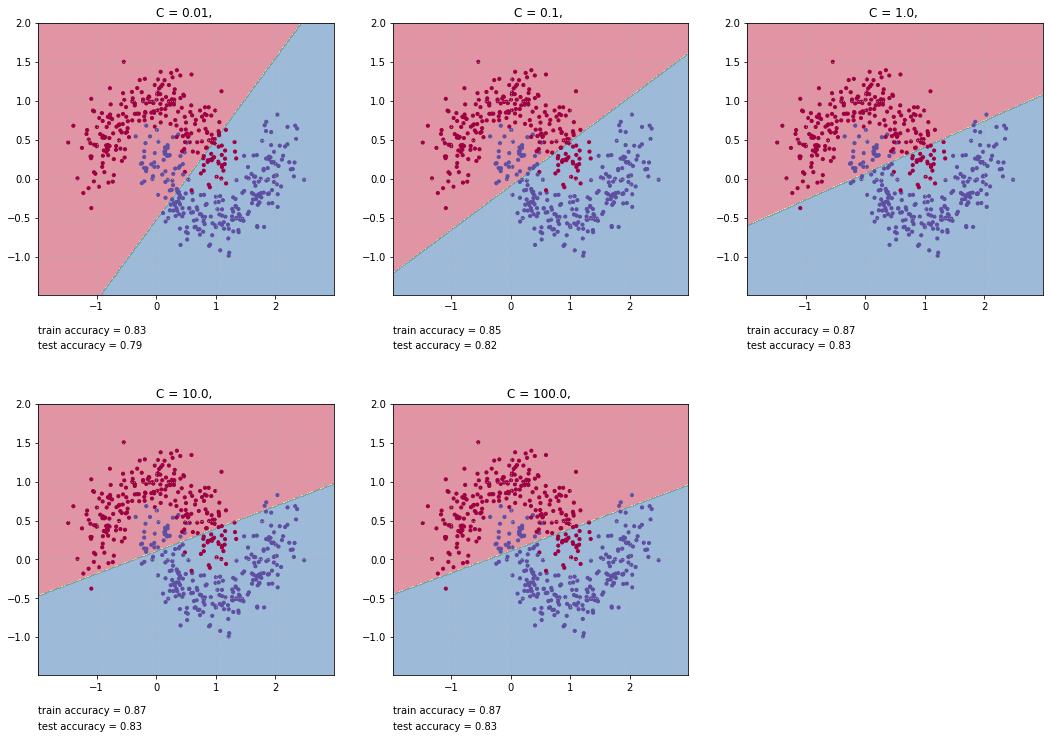

In [6]:
lr = [LogisticRegression(max_iter=1000, C=c) for c in np.logspace(-2, 2, 5)]
plot_decisions(moons_points, moons_labels, lr, ("C",))

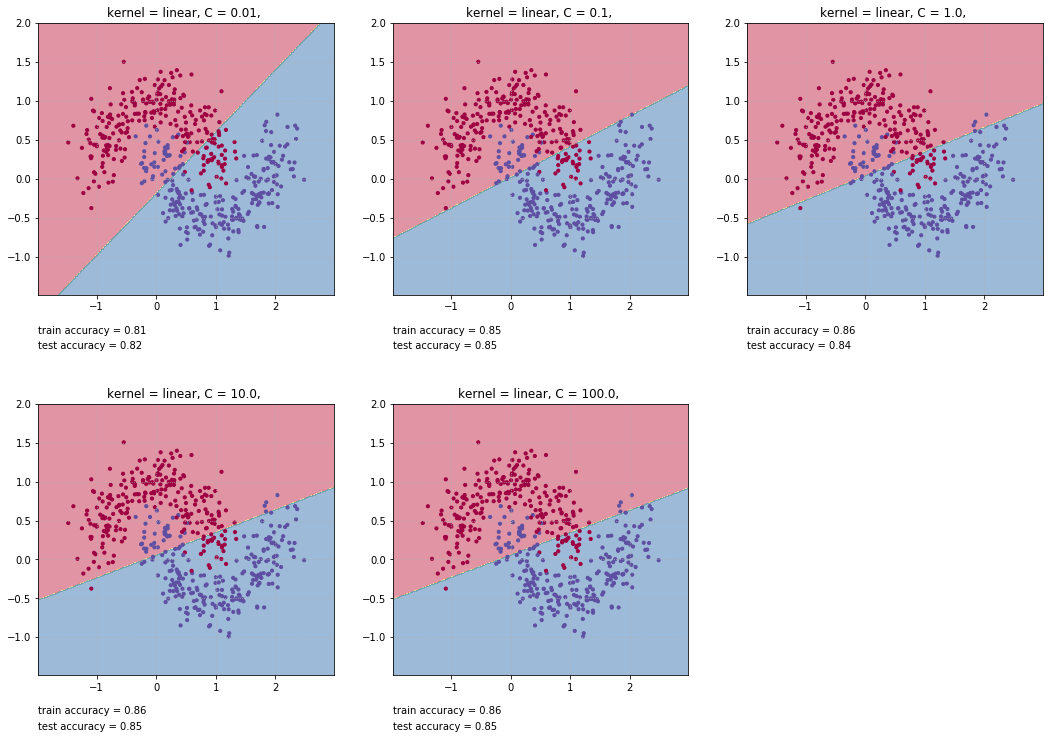

In [7]:
svm = [SVC(kernel='linear', C=c) for c in np.logspace(-2, 2, 5)]
plot_decisions(moons_points, moons_labels, svm, ("kernel", "C"))

*Better results in this particular case are provided for less values of regularization.*<br>
*However, overall imression is still poor because the sampling isn't linearly separable.*

## 1.2 Kernel trick

![keep-calm](imgs/keep-calm.jpg)

Now use different kernels (`poly`, `rbf`, `sigmoid`) on SVC to get better results. Play `degree` parameter and others.

For each kernel estimate optimal params, plot decision regions, calculate metric you've chosen eariler.

Write couple of sentences on:

* What have happenned with classification quality?
* How did decision border change for each kernel?
* What `degree` have you chosen and why?

Linear Kernel: $K(X,Y)=X^TY$

Polynomial kernel: $K(X,Y)=(\gamma⋅X^TY+r)^d,\,\gamma>0$

Radial Basis Function Kernel: $K(X,Y)=e^{−\gamma⋅\|X−Y\|^2}, \,\gamma>0$

Sigmoid Kernel: $K(X,Y)=\tanh(\gamma⋅X^TY+r)$

Here $r=coef0$, $d=degree$, and $\gamma =gamma$ are kernel parameters.

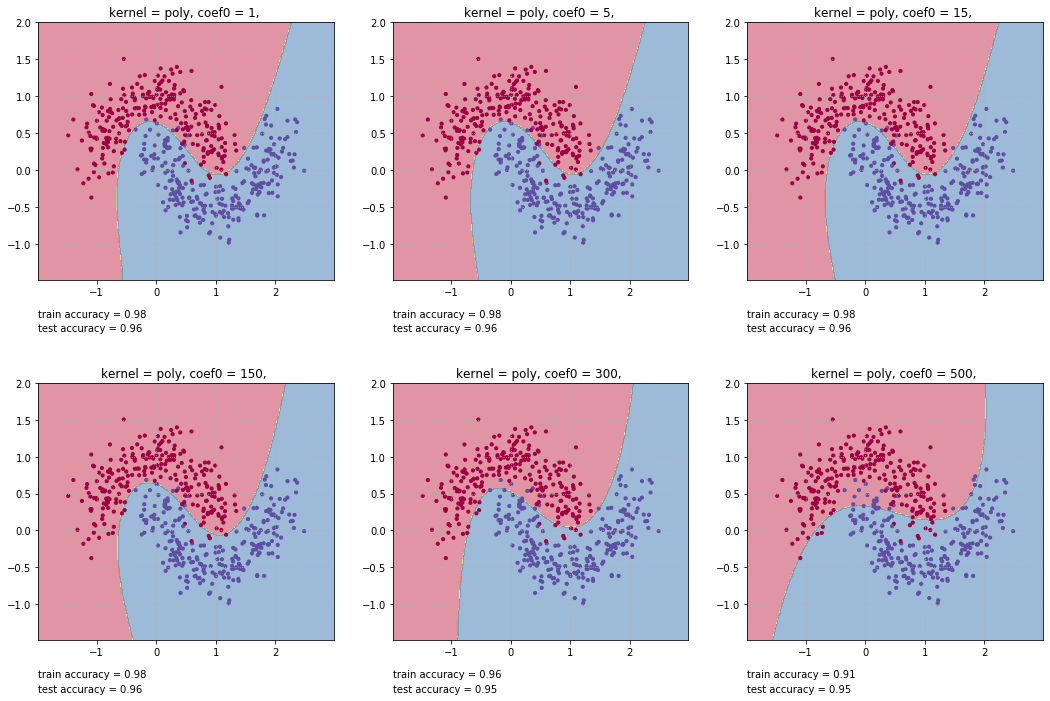

In [8]:
svm_poly = [SVC(kernel='poly', degree=3, gamma=1, coef0=coef0) for coef0 in (1, 5, 15, 150, 300, 500)]
plot_decisions(moons_points, moons_labels, svm_poly, ("kernel", "coef0"))

*Classification quality increased dramatically.*<br>
*Border type: curve*<br>
*I've chosen degree = 3, because border bound is a curve that resembles a polynom with the same degree as the hyperparameter, so degree = 3 is quite enough for classifing something not too complicated. Just like this exact case.*

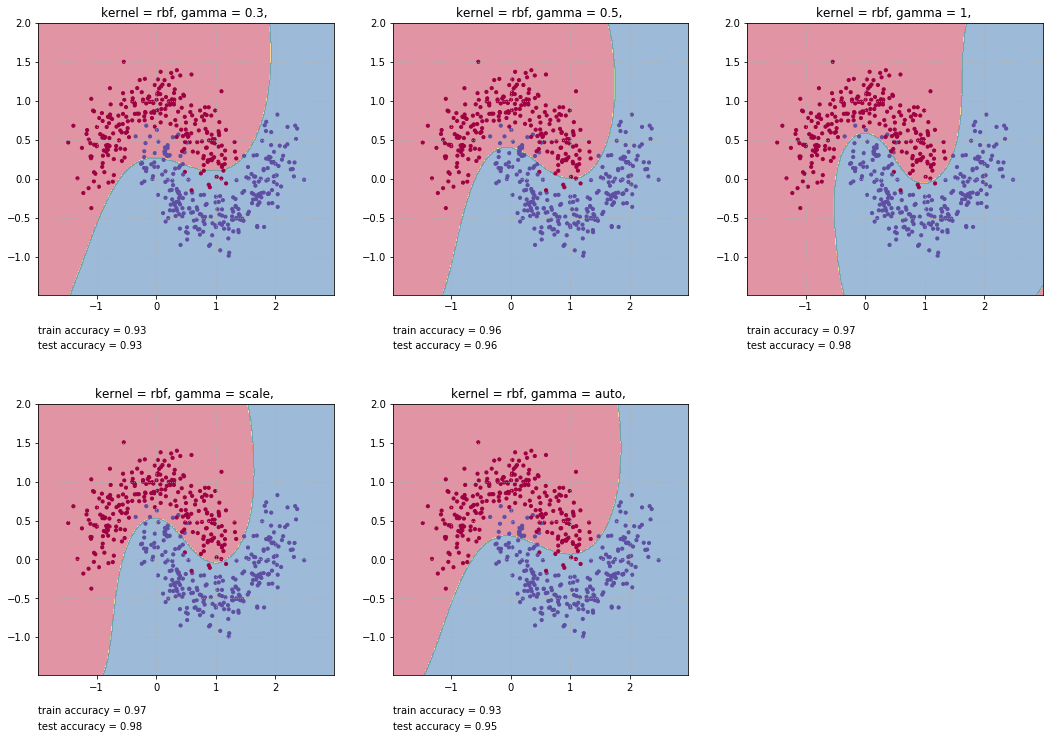

In [9]:
svm_rbf = [SVC(kernel='rbf', gamma=gamma) for gamma in (.3, .5, 1, 'scale', 'auto')]
plot_decisions(moons_points, moons_labels, svm_rbf, ("kernel", "gamma"))

*Border type: closed curve*<br>
*gamma = 'scale' = 1 / (n_features * X.var()) $\approx$ 0.89 looks really promising.*

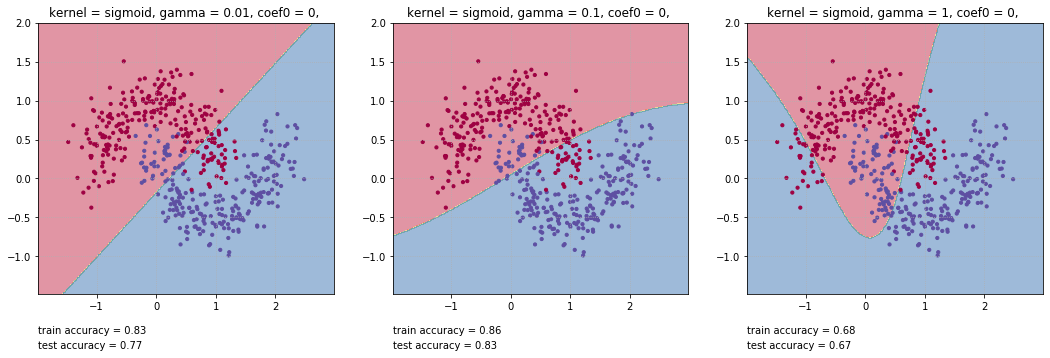

In [10]:
svm_sigmoid = [SVC(kernel='sigmoid', gamma=gamma, coef0=0) for gamma in (.01, .1, 1)]
plot_decisions(moons_points, moons_labels, svm_sigmoid, ("kernel", "gamma", "coef0"))

*This time I failed to choose hyperparameters that would allow to predict as precise as in two previous cases.*<br>
*However, gamma = 0.1 and coef0 = 0 seems the best possible option here.*

## 1.3 Simpler solution (of a kind)
What if we could use Logistic Regression to successfully solve this task?

Feature generation is a thing to help here. Different techniques of feature generation are used in real life, couple of them will be covered in additional lectures.

In particular case simple `PolynomialFeatures` ([link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)) are able to save the day.

Generate the set of new features, train LR on it, plot decision regions, calculate metric.

* Compare SVM's results with this solution (quality, borders type)
* What degree of PolynomialFeatures have you used? Compare with same SVM kernel parameter.

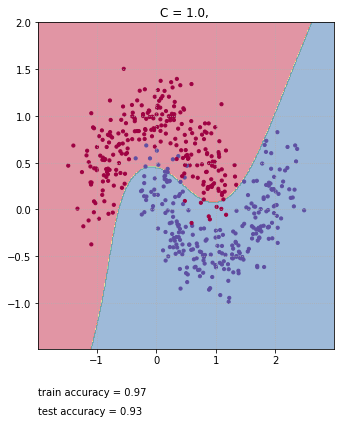

In [11]:
lr = [LogisticRegression(max_iter=1000)]
plot_decisions(moons_points, moons_labels, lr, ('C'), degree=3)

*Classification quality is comparable to SVC polynomial kernel case.*<br>
*As well as in poly kernel case, degree = 3 seems sufficient to express enough dependences for successful classification (classifier's able to operate cubic features and there is no need to increase degree even more).*

## 1.4 Harder problem

Let's make this task a bit more challenging via upgrading dataset:

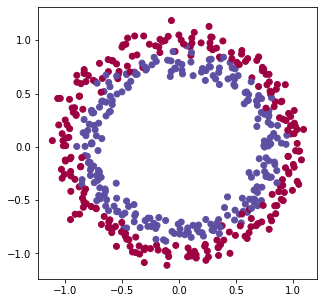

In [90]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score

circles_points, circles_labels = make_circles(n_samples=500, noise=0.06, random_state=42)

plt.figure(figsize=(5, 5))
plt.scatter(circles_points[:, 0], circles_points[:, 1], c=circles_labels, cmap=plt.cm.Spectral)
plt.show()

And even more:

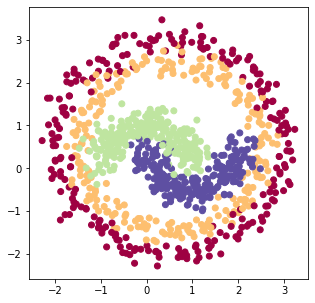

In [13]:
points = np.vstack((circles_points*2.5 + 0.5, moons_points))
labels = np.hstack((circles_labels, moons_labels + 2)) # + 2 to distinct moons classes
plt.figure(figsize=(5, 5))
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=plt.cm.Spectral)
plt.show()

Now do your best using all the approaches above!

Tune LR with generated features, SVM with appropriate kernel of your choice. You may add some of your loved models to demonstrate their (and your) strength. Again plot decision regions, calculate metric.

Justify the results in a few phrases.

*Applying SVM to the problem:*

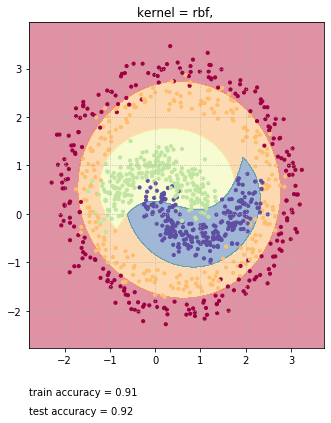

In [31]:
svm = [SVC(kernel='rbf', probability=True)]
plot_decisions(points, labels, svm, ('kernel',))

*Applying Logistic Regression with polynomial features to the problem:*

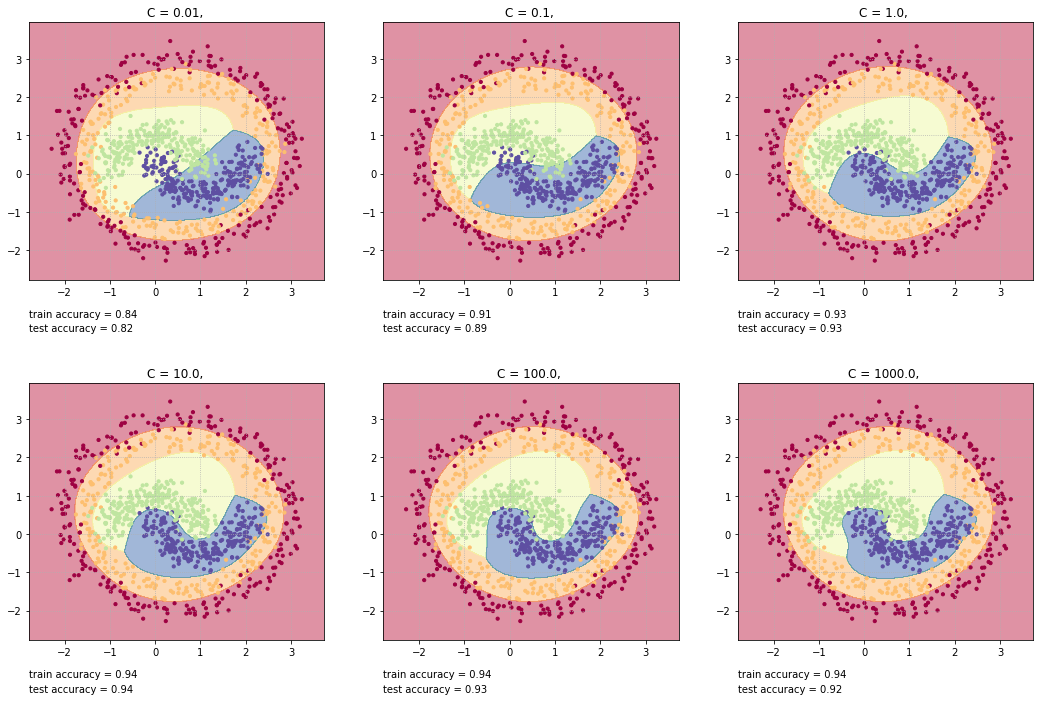

In [18]:
lr = [LogisticRegression(max_iter=10000, C=c) for c in np.logspace(-2, 3, 6)]
plot_decisions(points, labels, lr, degree=4, params=('C',))

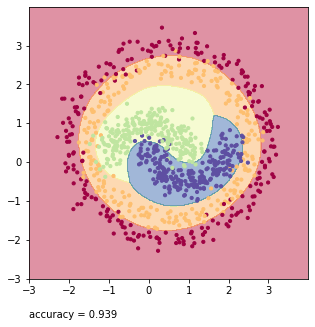

In [96]:
poly_1 = PolynomialFeatures(degree=1, interaction_only=False)
poly_4 = PolynomialFeatures(degree=4, interaction_only=False)

lr[4].fit(poly_4.fit_transform(points), labels)
svm[0].fit(poly_1.fit_transform(points), labels)

xx, yy = np.meshgrid(np.arange(-3, 4, 1e-2), np.arange(-3, 4, 1e-2))
prob_lr = lr[4].predict_proba(poly_4.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
prob_svm = svm[0].predict_proba(poly_1.fit_transform(np.c_[xx.ravel(), yy.ravel()]))
Z = (0.4 * prob_lr + 0.6 * prob_svm).argmax(axis=1)
Z = Z.reshape(xx.shape)

lr_points_prob = lr[4].predict_proba(poly_4.fit_transform(points))
svm_points_prob = svm[0].predict_proba(poly_1.fit_transform(points))
plt.figure(figsize=(5, 5))
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.5)
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=plt.cm.Spectral, s=10)
plt.text(-3,
         -4,
         'accuracy = ' + str(accuracy_score(labels,
                                            (0.4 * lr_points_prob + 0.6 * svm_points_prob).argmax(axis=1))))
plt.show()

*Just combining two mentioned classifiers to get new compromise classifier*